<span style="font-size: 16px;"><b>Model 2: multi-stock regression</b></span>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_datareader.data as web
import numpy as np
import pandas as pd

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# we modify this data organizing slightly to get two symbols
def get_prices(symbol):
    start, end = '2007-05-02', '2018-12-01'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):  # use list for getting more than one company's data
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))  # get price and returns for each symbol in list
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)

In [3]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

In [4]:
sess = tf.InteractiveSession()

In [5]:
# once again I only make slight modifications

# define placeholders 
x = tf.placeholder(tf.float32, [None, len(symbol_list) * 100])
y_ = tf.placeholder(tf.float32, [None, len(symbol_list)])

# define trainable variables
W = tf.Variable(tf.random_normal([len(symbol_list) * 100, len(symbol_list)]))
b = tf.Variable(tf.random_normal([len(symbol_list)]))

# we define our model: y = W*x + b
y = tf.matmul(x, W) + b

#MSE:
cost = tf.reduce_sum(tf.pow(y-y_, 2))/(2*1000)
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(cost)

In [6]:
# initialize variables to random values
init = tf.global_variables_initializer()
sess.run(init)
# run optimizer on entire training data set many times
for epoch in range(20000):
    sess.run(optimizer, feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%1000== 0:
        c = sess.run(cost, feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))

Epoch: 1000 cost= 0.044940758
Epoch: 2000 cost= 0.022995453
Epoch: 3000 cost= 0.014434166
Epoch: 4000 cost= 0.009697744
Epoch: 5000 cost= 0.006901416
Epoch: 6000 cost= 0.005188875
Epoch: 7000 cost= 0.004108568
Epoch: 8000 cost= 0.003409809
Epoch: 9000 cost= 0.002948113
Epoch: 10000 cost= 0.002637474
Epoch: 11000 cost= 0.002425221
Epoch: 12000 cost= 0.002278258
Epoch: 13000 cost= 0.002175336
Epoch: 14000 cost= 0.002102545
Epoch: 15000 cost= 0.002050619
Epoch: 16000 cost= 0.002013296
Epoch: 17000 cost= 0.001986291
Epoch: 18000 cost= 0.001966639
Epoch: 19000 cost= 0.001952260
Epoch: 20000 cost= 0.001941692


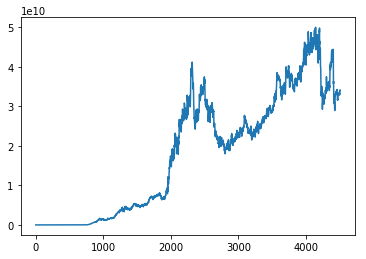

In [9]:
#train results
predict = y
p = sess.run(predict, feed_dict={x: train_ins})
position = 2*((p>0)-.5)
returns= position * train_outs
# daily_returns = sum(returns,1)
# plt.plot(np.cumprod(daily_returns+1))
plt.plot(np.cumprod(returns+1))

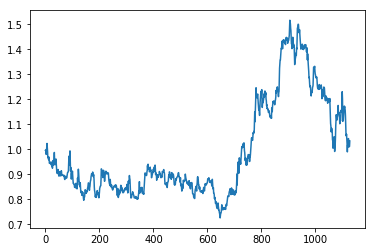

In [10]:
#test results
predict = y
p = sess.run(predict, feed_dict={x: test_ins})
position = 2*((p>0)-.5)
returns= position * test_outs
# daily_returns = sum(returns,1)
# plt.plot(np.cumprod(daily_returns+1))
plt.plot(np.cumprod(returns+1))